In [1]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from textblob import TextBlob

In [2]:
df = pd.read_csv("steam_games.csv")


In [3]:
df.head()

,AppID,Game Name,Game Tags,Release Date,Developer,Publisher,Price (in Rupees)
0,578080,PUBG: BATTLEGROUNDS,Survival Shooter Battle Royale Multiplayer FPS...,"21 Dec, 2017",PUBG Corporation,"KRAFTON, Inc.",Free To Play
1,1623730,Palworld,Open World Survival Creature Collector Multipl...,"18 Jan, 2024",Pocketpair,Pocketpair,"₹ 2,160"
2,1172470,Apex Legends™,Free to Play Battle Royale Multiplayer FPS Sho...,"4 Nov, 2020",Respawn,Electronic Arts,Free To Play
3,1063730,New World: Aeternum,Open World Massively Multiplayer MMORPG RPG Ad...,"28 Sep, 2021",Amazon Games,Amazon Games,"₹ 6,676"
4,550,Left 4 Dead 2,Zombies Co-op FPS Multiplayer Shooter Online C...,"16 Nov, 2009",Valve,Valve,₹ 720


In [4]:
def convert_price(price):
    # Extract digits from the price string
    match = re.findall(r'\d+', str(price).replace(',', ''))
    if match:
        return int(''.join(match))
    else:
        return 0

df['Price (in Rupees)'] = df['Price (in Rupees)'].apply(convert_price)

In [5]:
df.head()

,AppID,Game Name,Game Tags,Release Date,Developer,Publisher,Price (in Rupees)
0,578080,PUBG: BATTLEGROUNDS,Survival Shooter Battle Royale Multiplayer FPS...,"21 Dec, 2017",PUBG Corporation,"KRAFTON, Inc.",0
1,1623730,Palworld,Open World Survival Creature Collector Multipl...,"18 Jan, 2024",Pocketpair,Pocketpair,2160
2,1172470,Apex Legends™,Free to Play Battle Royale Multiplayer FPS Sho...,"4 Nov, 2020",Respawn,Electronic Arts,0
3,1063730,New World: Aeternum,Open World Massively Multiplayer MMORPG RPG Ad...,"28 Sep, 2021",Amazon Games,Amazon Games,6676
4,550,Left 4 Dead 2,Zombies Co-op FPS Multiplayer Shooter Online C...,"16 Nov, 2009",Valve,Valve,720


In [6]:
np.random.seed(42)
def mock_reviews():
    samples = [
        "Game crashes often.",
        "Loved the graphics, but buggy AI.",
        "Smooth experience, no issues.",
        "Encountered major bugs during missions.",
        "Great multiplayer mode."
    ]
    return np.random.choice(samples, size=20, replace=True).tolist()

df["Reviews"] = df["AppID"].apply(lambda x: mock_reviews())

In [7]:
# Preprocess reviews (no NLTK tokenizer)
stop_words = set(stopwords.words("english"))

def preprocess_reviews(reviews):
    clean_reviews = []
    for review in reviews:
        review = review.lower()
        review = re.sub(r"[^a-zA-Z\s]", "", review)
        words = review.split()
        filtered = [word for word in words if word not in stop_words]
        clean_reviews.append(" ".join(filtered))
    return clean_reviews

df["Cleaned Reviews"] = df["Reviews"].apply(preprocess_reviews)

In [8]:
# Extract bug/error related reviews
def is_bug_related(review_list):
    bug_keywords = ["bug", "error", "crash", "glitch", "issue", "problem"]
    bug_reviews = [r for r in review_list if any(kw in r for kw in bug_keywords)]
    return bug_reviews

df["Bug Reviews"] = df["Cleaned Reviews"].apply(is_bug_related)

In [9]:
def sentiment_score(reviews):
    if not reviews:
        return 0
    return np.mean([TextBlob(r).sentiment.polarity for r in reviews])

df["Bug Sentiment"] = df["Bug Reviews"].apply(sentiment_score)

In [10]:
df.columns

Index(['AppID', 'Game Name', 'Game Tags', 'Release Date', 'Developer',
       'Publisher', 'Price (in Rupees)', 'Reviews', 'Cleaned Reviews',
       'Bug Reviews', 'Bug Sentiment'],
      dtype='object')

In [11]:
df["Negative Bug"] = df["Bug Sentiment"] < 0


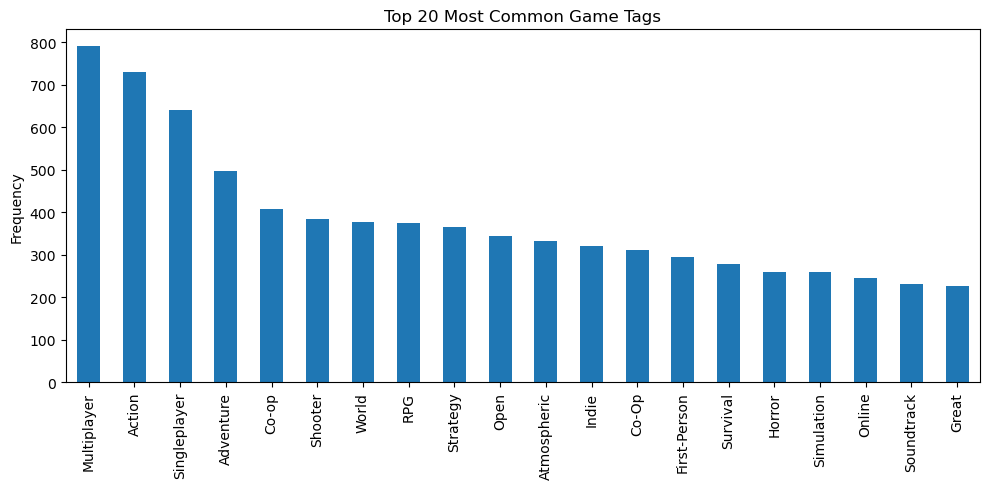

In [12]:
plt.figure(figsize=(10,5))
df['Game Tags'].str.split().explode().value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Most Common Game Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [13]:
# Price range cluster
df_price = df.dropna(subset=["Price (in Rupees)"])
kmeans = KMeans(n_clusters=4, random_state=42)
df_price["Price Cluster"] = kmeans.fit_predict(df_price[["Price (in Rupees)"]])

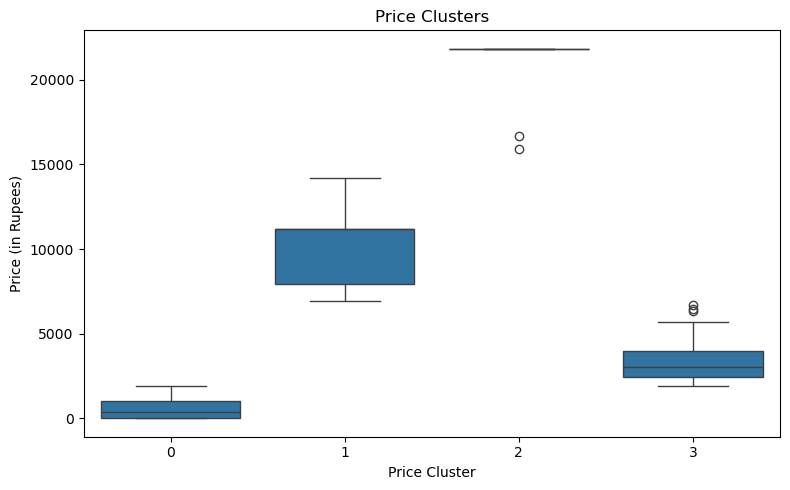

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_price, x="Price Cluster", y="Price (in Rupees)")
plt.title("Price Clusters")
plt.tight_layout()
plt.show()

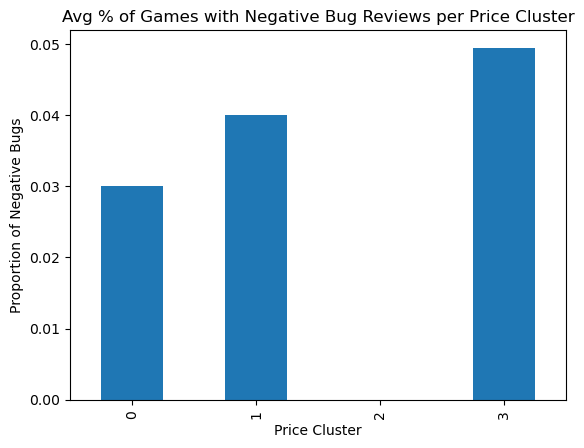

In [15]:
# Avg negative bug reports by cluster
cluster_bug = df_price.groupby("Price Cluster")["Negative Bug"].mean()
cluster_bug.plot(kind='bar', title="Avg % of Games with Negative Bug Reviews per Price Cluster")
plt.ylabel("Proportion of Negative Bugs")
plt.xlabel("Price Cluster")
plt.show()

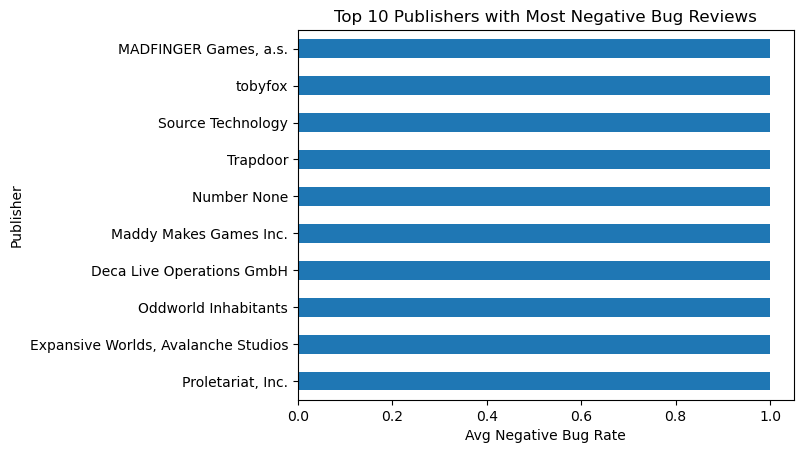

In [16]:

# Publisher vs. negative bugs
pub_bug = df.groupby("Publisher")["Negative Bug"].mean().sort_values(ascending=False).head(10)
pub_bug.plot(kind="barh", title="Top 10 Publishers with Most Negative Bug Reviews")
plt.xlabel("Avg Negative Bug Rate")
plt.show()

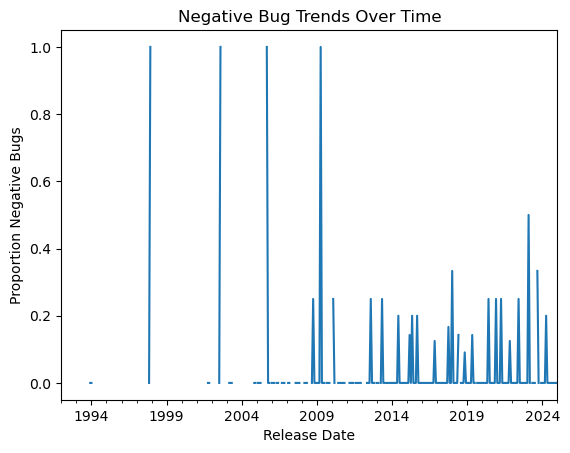

In [17]:
# Timeline of release vs bugs
df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")
df_time = df.dropna(subset=["Release Date"])
df_time.set_index("Release Date")["Negative Bug"].resample("M").mean().plot(title="Negative Bug Trends Over Time")
plt.ylabel("Proportion Negative Bugs")
plt.show()

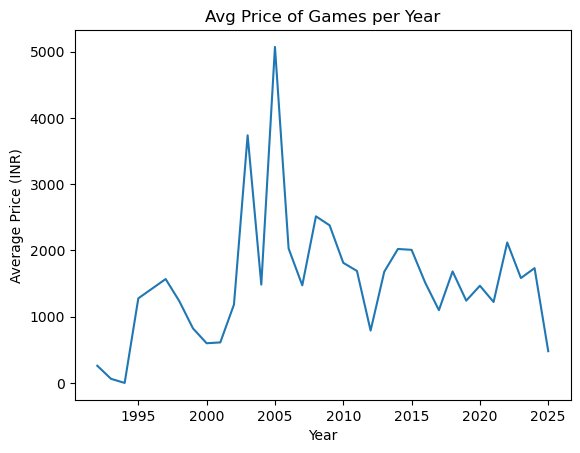

In [19]:
# Average price by year
if df["Release Date"].dtype == 'datetime64[ns]':
    df["Year"] = df["Release Date"].dt.year
    df.groupby("Year")["Price (in Rupees)"].mean().plot(title="Avg Price of Games per Year")
    plt.ylabel("Average Price (INR)")
    plt.show()

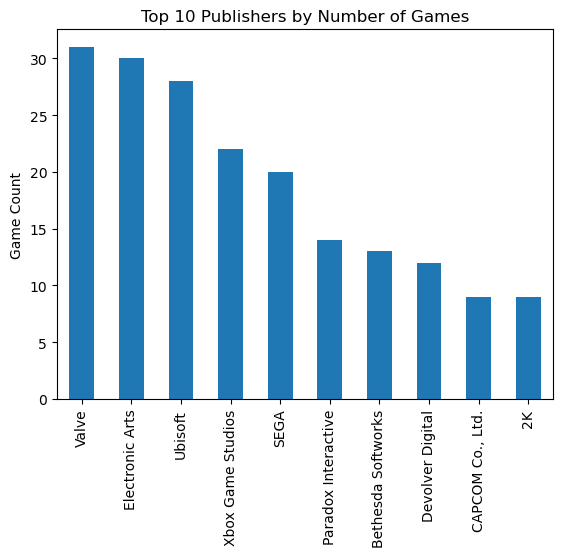

In [22]:

# Publisher count
pub_count = df["Publisher"].value_counts().head(10)
pub_count.plot(kind='bar', title="Top 10 Publishers by Number of Games")
plt.ylabel("Game Count")
plt.xticks(rotation=90)
plt.show()

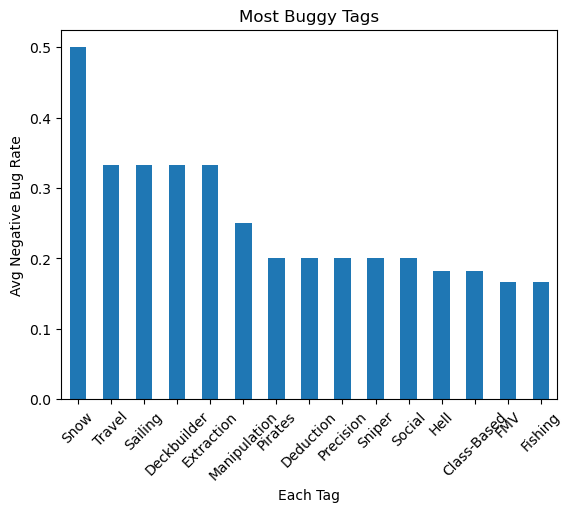

In [25]:
df["Each Tag"] = df["Game Tags"].str.split()
tag_bug = df.explode("Each Tag")
tag_bug = tag_bug.groupby("Each Tag")["Negative Bug"].mean().sort_values(ascending=False).head(15)
tag_bug.plot(kind="bar", title="Most Buggy Tags")
plt.ylabel("Avg Negative Bug Rate")
plt.xticks(rotation=45)
plt.show()

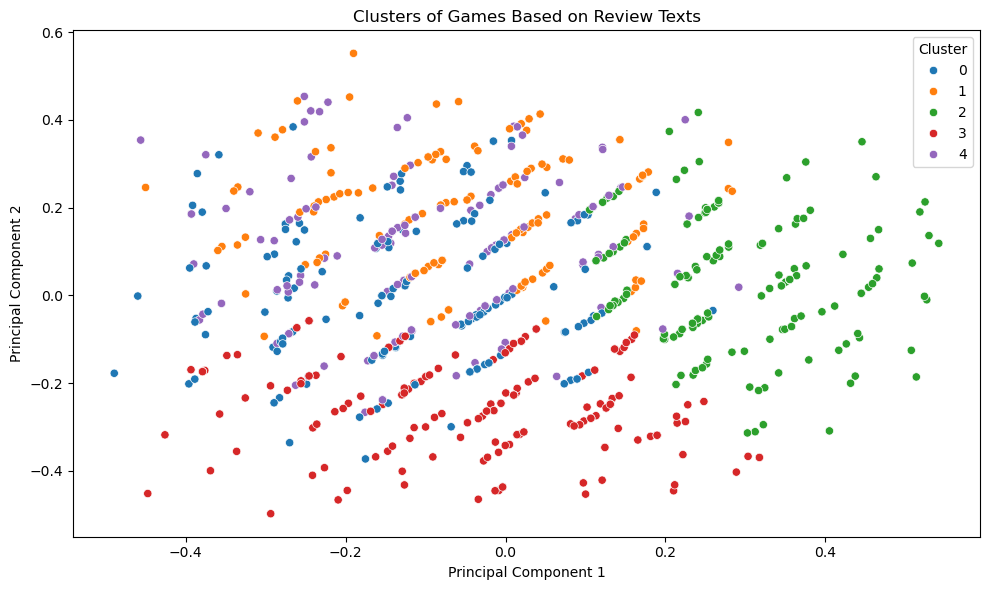

In [27]:
# -------- Cluster Based on Reviews --------

from sklearn.decomposition import PCA

# Convert all cleaned reviews to a single string per game
df["Combined Cleaned Reviews"] = df["Cleaned Reviews"].apply(lambda x: " ".join(x))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(df["Combined Cleaned Reviews"]).toarray()

# Clustering
kmeans_reviews = KMeans(n_clusters=5, random_state=42)
df["Review Cluster"] = kmeans_reviews.fit_predict(X)

# PCA for Visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X)
df["PCA1"] = components[:, 0]
df["PCA2"] = components[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Review Cluster", palette="tab10")
plt.title("Clusters of Games Based on Review Texts")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

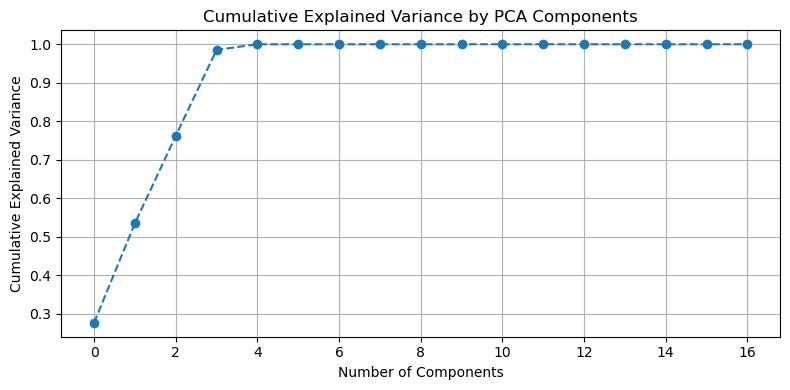

In [28]:
# Plot explained variance ratio to see how much information PCA retained
plt.figure(figsize=(8,4))
pca_full = PCA().fit(X)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
df_reviews = pd.read_csv('steam_all_game_reviews_with_cleaned.csv')

In [30]:
df_reviews

,AppID,Game Name,Review,Cleaned Review
0,578080,PUBG: BATTLEGROUNDS,How is this game in worse shape than probably ...,game worse shape probably early access release...
1,578080,PUBG: BATTLEGROUNDS,"It was revolutionary in 2017/18, but nowadays ...",revolutionary nowadays incredibly outdated clu...
2,578080,PUBG: BATTLEGROUNDS,It is March 2025 and PUBG;\r\n\r\n-is still no...,march pubg still optimized properly depends he...
3,578080,PUBG: BATTLEGROUNDS,"I like it, I'm not sure if I got better or bec...",like im sure got better bunch cheaters banned ...
4,578080,PUBG: BATTLEGROUNDS,Games just keep getting worse and not worth pl...,games keep getting worse worth playing anymore...
...,...,...,...,...
47027,9450,"Warhammer® 40,000: Dawn of War® - Soulstorm",DOW,dow
47028,9450,"Warhammer® 40,000: Dawn of War® - Soulstorm",Yes,yes
47029,9450,"Warhammer® 40,000: Dawn of War® - Soulstorm",orks,orks
47030,9450,"Warhammer® 40,000: Dawn of War® - Soulstorm",e,NaN


In [31]:
print(df_reviews.info())
print("\nMissing Values:\n", df_reviews.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47032 entries, 0 to 47031
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AppID           47032 non-null  int64 
 1   Game Name       47032 non-null  object
 2   Review          46989 non-null  object
 3   Cleaned Review  46403 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB
None

Missing Values:
 AppID               0
Game Name           0
Review             43
Cleaned Review    629
dtype: int64


In [37]:
review_counts = df_reviews.groupby("AppID")["Review"].count().sort_values(ascending=False)
print("\nTop 5 Games by Review Count:\n", review_counts.head())



Top 5 Games by Review Count:
 AppID
10        100
457140    100
504230    100
502500    100
495420    100
Name: Review, dtype: int64


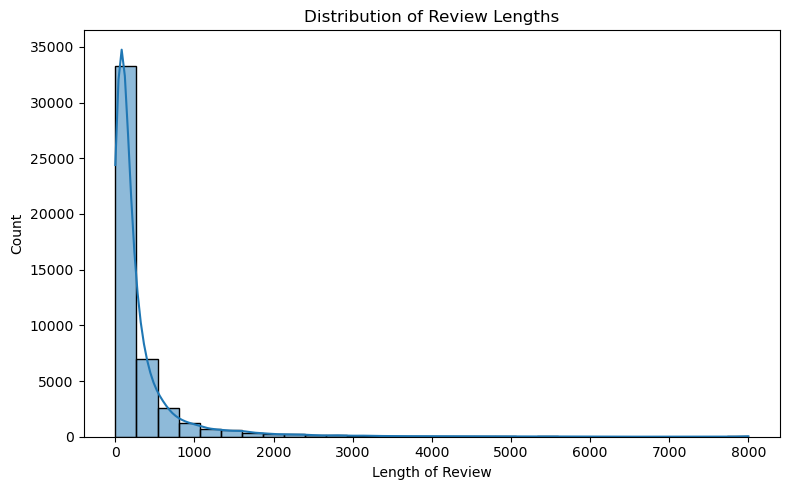

In [39]:
df_reviews["Review Length"] = df_reviews["Review"].astype(str).apply(len)
plt.figure(figsize=(8,5))
sns.histplot(df_reviews["Review Length"], bins=30, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Length of Review")
plt.tight_layout()
plt.show()

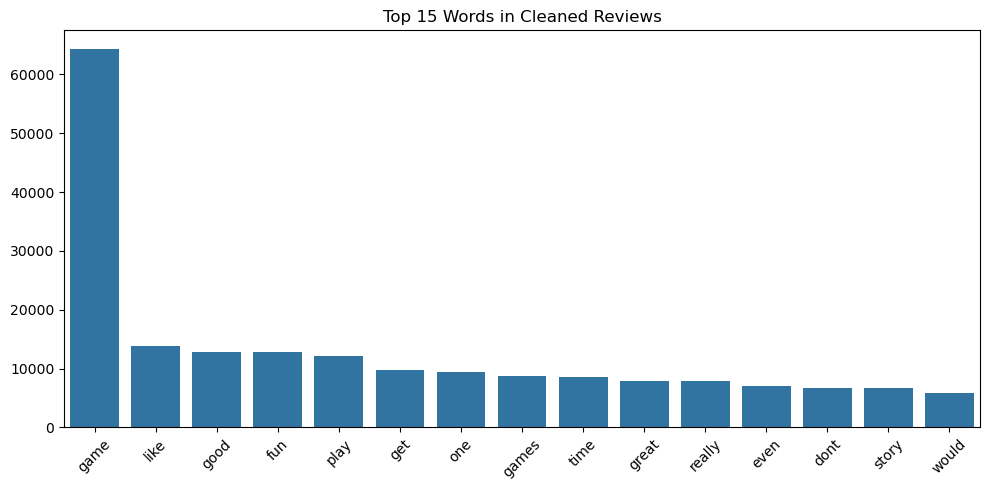

In [41]:
from collections import Counter
all_words = " ".join(df_reviews["Cleaned Review"].dropna().astype(str)).split()
common_words = Counter(all_words).most_common(15)
words, freqs = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(words), y=list(freqs))
plt.title("Top 15 Words in Cleaned Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
error_keywords = [
    "bug", "bugs", "crash", "crashing", "crashed", "glitch", "glitches",
    "error", "issue", "lag", "lagging", "freezing", "freeze", "broken",
    "problem", "problems", "unplayable", "disconnect", "stuck", "slow"
]

In [44]:
def contains_bug(review):
    return any(keyword in review for keyword in error_keywords)

df_reviews["is_bug"] = df_reviews["Cleaned Review"].astype(str).apply(contains_bug)

In [45]:
bug_rate = df_reviews.groupby("AppID")["is_bug"].mean().sort_values(ascending=False)
print("\nTop 5 Games with Most Bug Mentions:\n", bug_rate.head())


Top 5 Games with Most Bug Mentions:
 AppID
253900     1.0
33900      1.0
308040     1.0
311860     1.0
1343400    1.0
Name: is_bug, dtype: float64


In [46]:
# Sentiment analysis
df_reviews["sentiment"] = df_reviews["Cleaned Review"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
df_reviews["bug_sentiment"] = df_reviews.apply(lambda row: TextBlob(row["Cleaned Review"]).sentiment.polarity if row["is_bug"] else None, axis=1)


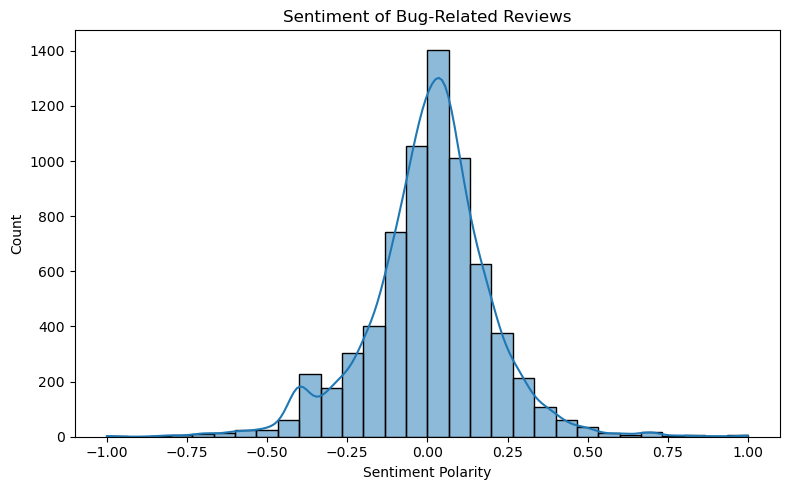

In [47]:
bug_sentiment = df_reviews.dropna(subset=["bug_sentiment"])
plt.figure(figsize=(8,5))
sns.histplot(bug_sentiment["bug_sentiment"], bins=30, kde=True)
plt.title("Sentiment of Bug-Related Reviews")
plt.xlabel("Sentiment Polarity")
plt.tight_layout()
plt.show()

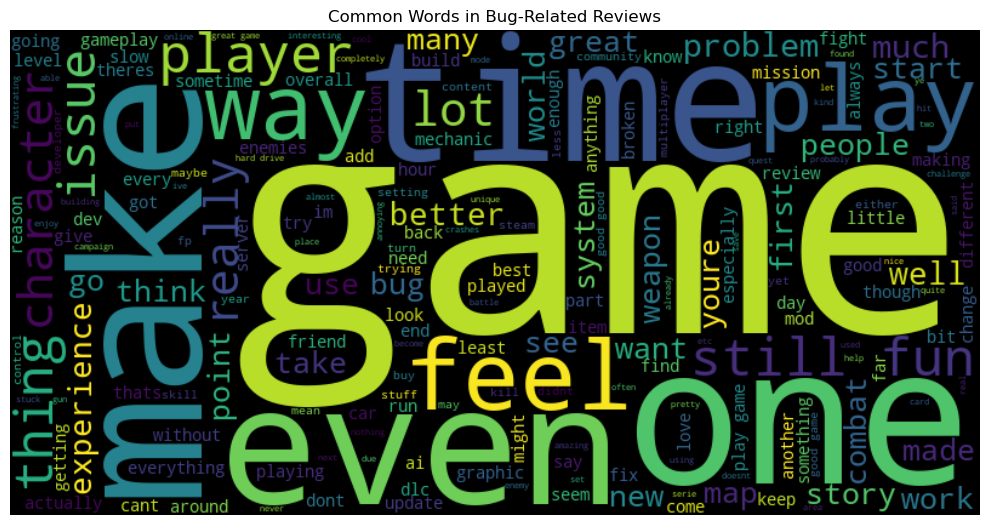

In [49]:
from wordcloud import WordCloud
bug_words = " ".join(df_reviews[df_reviews["is_bug"]]["Cleaned Review"].dropna())
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(bug_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Bug-Related Reviews")
plt.tight_layout()
plt.show()